# VAE and DDPM

## 前言
本笔记的目的是回顾 VAE 和 DDPM 的理论推导，并且用简单的代码例子实验他们

## VAE
VAE 假设真实数据背后存在一个隐变量 $z \sim p(z)$ ，真实样本 $x \sim p(x|z)$ 采样得到。这时我们观察到的样本 $x$ 服从分布 $p(x)$ ，并且 $p(x) = \int_z p(z)p(x|z)dz$。 

$z$ 与 $x$ 的概率图模型如下图所示：
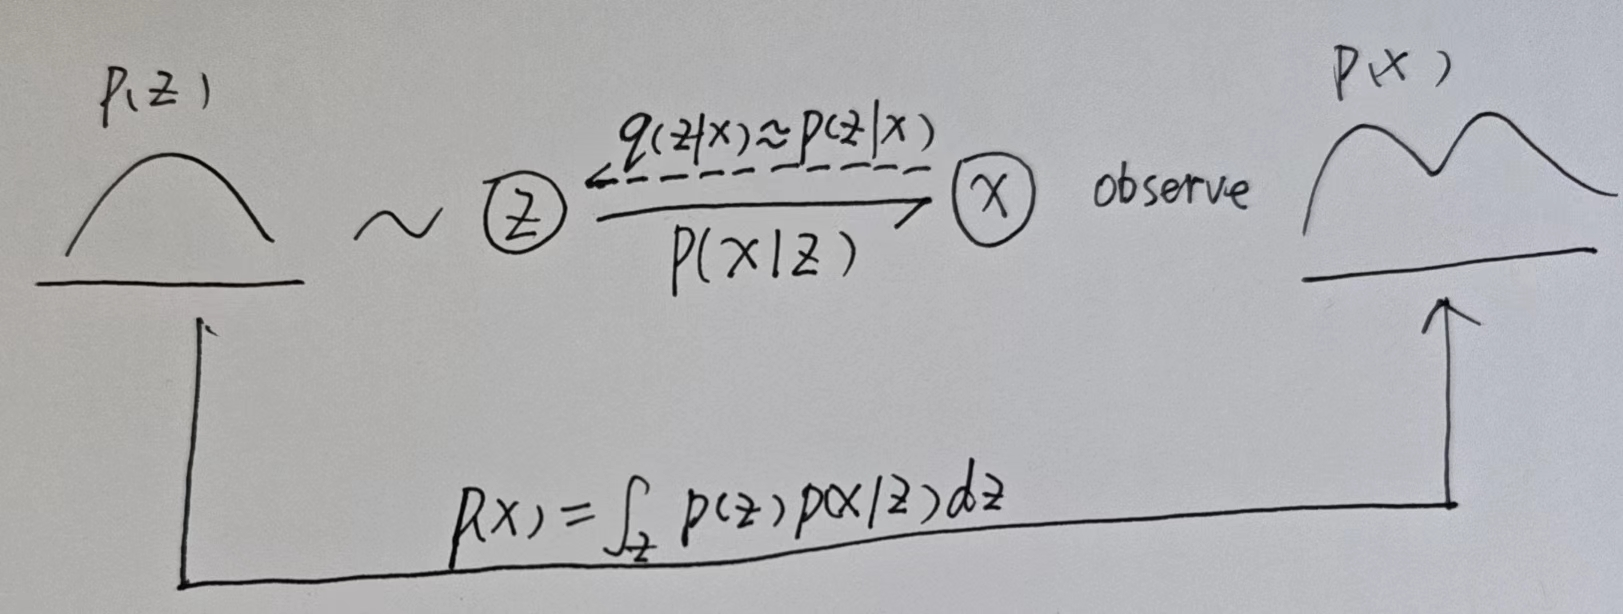

问题：给定样本 $x$，我们如何推断其对应的隐变量 $z$ 呢？

### 方案一：拟合 $p(x|z)$ + 贝叶斯公式

我们可以计算 $p(z|x)$ ：

$$
p(z|x) = \frac{p(z)p(x|z)}{p(x)}\qquad \cdots \qquad (1)
$$

公式(1)中我们有什么？

$p(z)$ 先验分布，我们可以假设其为标准正态分布（其他分布也可以，随便，好计算就行）。

$p(x|z), p(x)$ 两个分布的具体形式未知，但我们可以获取到 $p(x)$ 的信息，我们可以获取到样本 $x$。

也就是说，如果用网络去建模 $p_\theta (x|z)$ ，可以计算得到 $p_\theta (x) = \int_z p(z)p_\theta(x|z) dz$，通过极大似然估计可以估计出最优 

$$
\theta^* = \underset{\theta}{\arg\max}~\mathbb{E}_x [p_\theta(x)] = \underset{\theta}{\arg\max}~\mathbb{E}_x \mathbb{E}_z [p_\theta(x|z)]
$$

有了最优的 $\theta^*$ 之后，显然我们可以计算得到 

$$
p_{\theta^*}(z|x) = \frac{p(z)p_{\theta^*}(x|z)}{p_{\theta^*}(x)} \propto p(z)p_{\theta^*}(x|z)  \qquad \qquad \cdots \qquad \qquad (2)
$$

下面用代码来展示两个简单的例子：

例子一（设置 discrete 为 True or False, GMM 为 True）：

$$
p(z) = \left\{\begin{matrix}
1/5 & z=0\\
4/5 & z=1
\end{matrix}\right.
$$
$$
p(x|z) = \mathcal{N}(\mu_z, I)
$$

例子二（设置 discrete 为 False，GMM 为 False）：
$p(z)$ 为高斯分布，$p(x)$ 为上述的混合高斯分布，$p(x|z)$ 未知，希望成功建模 $p(x|z)$ 使得通过采样得到真实的 $p(x)$。

这里稍微回顾一下多元高斯分布的概率密度公式：

$$
p(\mathbf{x}) = \frac{1}{(2\pi)^{\frac{D}{2}}|\Sigma|^{\frac{1}{2}}} \exp ( (\mathbf{x}-\mathbf{\mu})^\top \Sigma ^{-1}(\mathbf{x}-\mathbf{\mu}))
$$


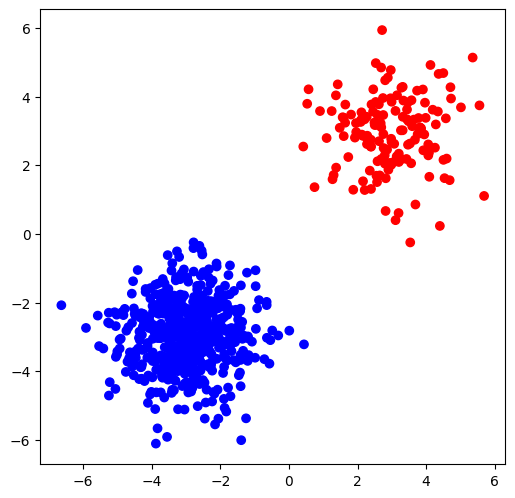

In [1]:
import torch

def sample_z(size: int) -> torch.Tensor:
    z_ = torch.rand(size)
    mask = (z_ < 1 / 5)
    z_[mask] = 0
    z_[~mask] = 1
    return z_

def sample_x1z(z: torch.Tensor) -> torch.Tensor:
    centers = torch.tensor([[3,3],[-3,-3]])
    x_ = torch.randn((z.shape[0], 2))
    x_ += centers[z.long()]
    return x_

def sample_z_new(size: int) -> torch.Tensor:
    return torch.randn(size)

total_sample = 1000
total_z = sample_z(total_sample)
total_x = sample_x1z(total_z)

train_ratio = 0.7
num_train = int(total_sample * train_ratio)
num_eval = total_sample - num_train

total_indices = torch.randperm(total_sample)
train_indices = total_indices[:num_train]
z = total_z[train_indices]
x = total_x[train_indices]

eval_indices = total_indices[num_train:]
eval_z = total_z[eval_indices]
eval_x = total_x[eval_indices]

from matplotlib import pyplot as plt
fig, axes = plt.subplots(1, 1, figsize=(6, 6))
axes.set_aspect(1)
axes.scatter(x[:,0], x[:,1], c=['r' if tmp == 0 else 'b' for tmp in z])
# axes.set_xlim([-5, 5])
# axes.set_ylim([-5, 5])

In [2]:
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import math

discrete = False
GMM = False

# 直接假设 p(x|z) 是一个协方差为 I 的高斯分布，网络输出 均值
if not discrete:
    if GMM:
        # 使用连续网络，例子一
        x1z_net = nn.Linear(1, 2)
    else:
        # 使用连续网络，例子二
        x1z_net = nn.Sequential(nn.Linear(1, 32), nn.ReLU(), nn.Linear(32, 32), nn.ReLU(), nn.Linear(32, 4))
else:
    if GMM: 
    # 例子一，离散的输入 z 建议采用离散形式的网络
        x1z_net = nn.Embedding(2, 2)
    else:
        raise RuntimeError

if GMM:
    lr = 1e-3
else:
    lr = 1e-3
    
optimizer = optim.Adam(x1z_net.parameters(), lr=lr)

total_iter = 10000
bs = 500
per_z_sampled = 200

count_0 = count_1 = 0

progress_bar = tqdm(range(total_iter))

for i in progress_bar:
    if GMM:
        # 例子一
        tmp_z = sample_z(per_z_sampled)
    else:
        # 例子二
        tmp_z = sample_z_new(per_z_sampled)
    
    if not discrete:
        if GMM:
            # 例子一，只建模均值，方差直接采用 I
            mus = x1z_net(tmp_z[:, None])
            var = torch.tensor([[1.0]])
        else:
            # 例子二，同时建模均值和方差，完成 p(z) -> p(x) 的映射
            mu_log_var = x1z_net(tmp_z[:, None])
            mus = mu_log_var[:, :2]
            log_var = mu_log_var[:, 2:]
            var = torch.exp(log_var) + 1e-6
    else:
        # 例子一，只建模均值，方差直接采用 I
        mus = x1z_net(tmp_z.long())
        var = torch.tensor([[1.0]])
        
    indices = torch.randint(0, num_train, (bs,))
    tmp_x = x[indices]

    # ps: 两两向量差值计算快捷方法
    # A: [a, d], B: [b, d]
    # A[:, None, :] - B[None, :, :] 可得到 A，B 矩阵行向量的两两差值，进而可以计算两两距离
    minus = (tmp_x[:, None, :] - mus[None, :, :]) / torch.sqrt(var[None, :, :])
    pair_dist = torch.sum(minus * minus, dim=-1)
    
    # 计算每个 p(x|z) 的值，2元高斯分布概率密度计算公式
    all_p = 1 / (2 * math.pi) * torch.exp(-1/2 * pair_dist) / torch.exp(torch.sum(log_var / 2, dim=-1))[None, :]
        
    # 通过对 z 求期望获得 p(x)
    e_z_x1z = torch.mean(all_p, dim=-1)

    # 通过对 x 求期望得到最后负对数似然
    e_x_log_p_x = torch.mean(-torch.log(e_z_x1z))
    nll = e_x_log_p_x
    if i % 1000 == 0:
        progress_bar.set_postfix(loss=nll.item())
    optimizer.zero_grad()
    nll.backward()
    optimizer.step()

100%|████████████████████████████████████████████████████████████████| 10000/10000 [00:35<00:00, 282.72it/s, loss=3.42]


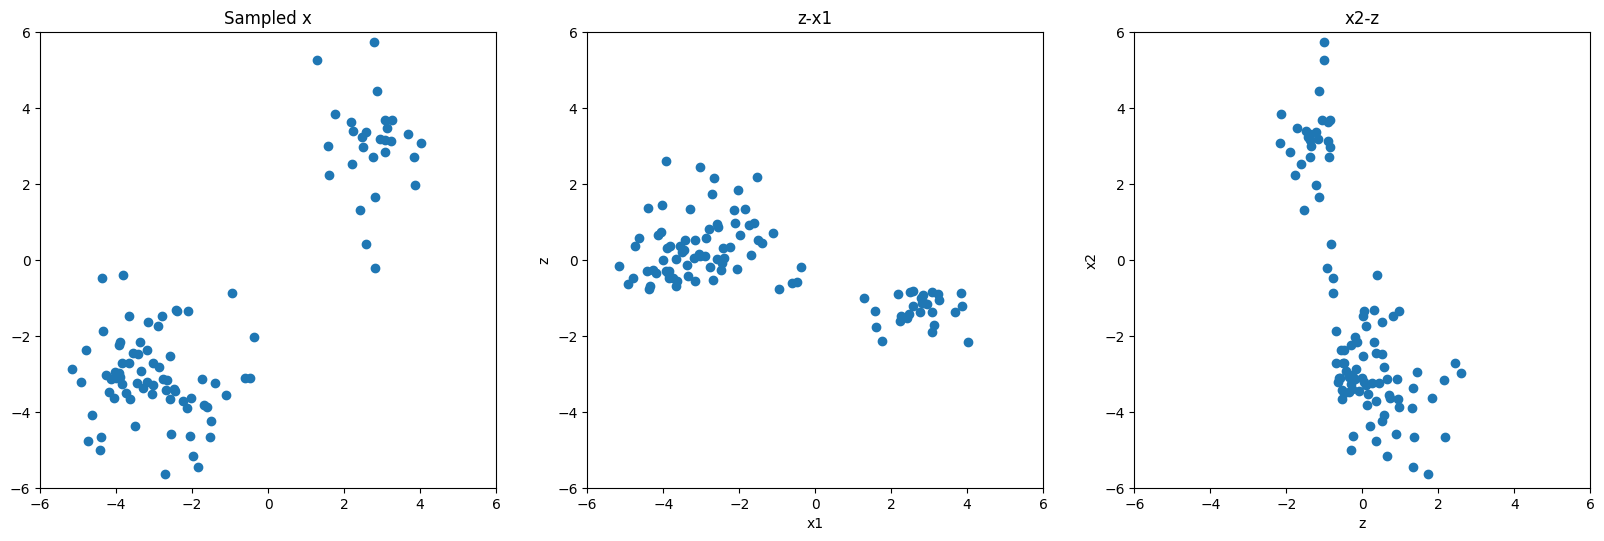

In [3]:
with torch.no_grad():
    if GMM:
        # 例子一，展示拟合出的中心点，并且对测试集做潜变量推断
        if not discrete:
            centers = x1z_net(torch.tensor([[0.0], [1.0]]))
        else:
            centers = x1z_net(torch.tensor([0, 1]))
        print(f"center0: ({centers[0][0].item():.2f}, {centers[0][1].item():.2f})")
        print(f"center1: ({centers[1][0].item():.2f}, {centers[1][1].item():.2f})")
        
        # 做潜变量推断，正确的用绿色，错误的用红色
        tmp_z = sample_z(per_z_sampled)
    
        zero_mask = (tmp_z < 0.5)
        
        if not discrete:
            mus = x1z_net(tmp_z[:, None])
        else:
            mus = x1z_net(tmp_z.long())
            
        # 计算两两之间距离
        sq_mus = torch.sum(mus * mus, dim=-1)
        indices = torch.randint(0, num_train, (bs,))
        tmp_x = eval_x
        sq_x = torch.sum(tmp_x * tmp_x, dim=-1)
        pair_dist = sq_x[:, None] - 2 * tmp_x @ mus.T + sq_mus[None, :]
        # 计算每个 p(x|z) 的值
        all_p = 1 / (2 * math.pi) * torch.exp(-1/2 * pair_dist)
    
        p_z_0 = torch.sum(all_p[:, zero_mask], dim=-1) * torch.sum(zero_mask) / per_z_sampled
        p_z_1 = torch.sum(all_p[:, ~zero_mask], dim=-1) * torch.sum(~zero_mask) / per_z_sampled
        pre_z = (p_z_0 < p_z_1)
        accurate = pre_z.float() - eval_z
        fig, axes = plt.subplots(1, 1, figsize=(6, 6))
        axes.set_aspect(1)
        axes.scatter(eval_x[:,0], eval_x[:,1], c=['g' if tmp == 0 else 'r' for tmp in accurate])
    else:
        # 例子二，采100个样本点试试水，看看是否符合 p(x)
        num_sample = 100
        z = sample_z_new(num_sample)
        mu_log_var = x1z_net(z[:, None])
        mus = mu_log_var[:, :2]
        log_var = mu_log_var[:, 2:]
        std = torch.sqrt(torch.exp(log_var))
#         std = torch.exp(log_var)

        epsilon = torch.randn([num_sample, 2])

        out_x = mus + std * epsilon
        
        fig, axes_list = plt.subplots(1, 3, figsize=(20, 6))
        ax1, ax2, ax3 = axes_list
        ax1.set_aspect(1)
        ax2.set_aspect(1)
        ax3.set_aspect(1)
        ax1.set_xlim([-6,6])
        ax1.set_ylim([-6,6])
        ax2.set_xlim([-6,6])
        ax2.set_ylim([-6,6])
        ax3.set_xlim([-6,6])
        ax3.set_ylim([-6,6])
        
        ax1.scatter(out_x[:,0], out_x[:,1])
        ax1.set_title('Sampled x')
        ax2.set_xlabel('x1')
        ax2.set_ylabel('x2')
        
        # Plot z vs. x1
        ax2.scatter(out_x[:, 0].detach().numpy(), z.detach().numpy(), label='x1 from z')
        ax2.set_title('z-x1')
        ax2.set_xlabel('x1')
        ax2.set_ylabel('z')
        
        # Plot z vs. x2
        ax3.scatter(z.detach().numpy(), out_x[:, 1].detach().numpy(), label='x2 from z')
        ax3.set_title('x2-z')
        ax3.set_xlabel('z')
        ax3.set_ylabel('x2')
    

通过上面的例子我们看到，我们确实可以通过拟合 $p(x|z)$ 的方式实现潜变量推断或者从一个先验分布变换到另一个已知数据分布（生成式）。

但是我们可以看到的是：当潜变量是连续变量时，采用公式（2）做潜变量推断十分困难；对于更难的数据分布，通过这种无配对的 $(x, z)$ 去学习 $p(x|z)$ 将会更加困难，网络需要遍历更加复杂的空间来完成 $p(x|z)$ 的构建。

### 方案二：拟合 $p(z|x)$ 做变分推断

我们可以尝试使用 $q(z|x)$ 去拟合 $p(z|x)$，使用反向KL作为目标函数：

$$
\begin{aligned}
KL\left( q(z|x)\|p(z|x) \right) = & \mathbb{E}_{q(z|x)} \log \frac{q(z|x)}{p(z|x)}  \\
= & \mathbb{E}_{q(z|x)} \log \frac{q(z|x)p(x)}{p(x,z)} = \mathbb{E}_{q(z|x)} \log \frac{q(z|x)}{p(x,z)} + \mathbb{E}_{q(z|x)} \log p(x) \\
= & \mathbb{E}_{q(z|x)} \log \frac{q(z|x)}{p(x,z)} + \log p(x) \\
= & \mathbb{E}_{q(z|x)} \log \frac{q(z|x)}{p(x|z) p(z)} + \log p(x) \\
= & \underset{潜变量先验拟合}{\underbrace{KL(q(z|x) \| p(z))}} - \underset{样本重建}{\underbrace{\mathbb{E}_{q(z|x)} \log p(x|z)}} + \underset{对数似然}{\underbrace{\log p(x)}}
\end{aligned}
$$

整理一下：
$$
\log p(x) - KL\left( q(z|x)\|p(z|x) \right) = \mathbb{E}_{q(z|x)} \log p(x|z) - KL(q(z|x) \| p(z)) = ELBO(x)
$$

情景一：在知道 $p(x|z)$ 的情况下，我们可以自主选择 $p(z)$ 的形式，然后最大化 $ELBO(x)$，等价于最小化 $q(z|x)$ 和真实 $p(z|x)$ 的距离。

情景二：真实 $p(x|z)$ 位置情况下，我们可以用 $p_\theta(x|z)$ 拟合 $p(x|z)$，使用 $q_\phi (z|x)$ 拟合 $q(z|x)$。这个时候优化 $ELBO(x)$，等价于同时做极大似然估计 和 最小化 $q(z|x)$ 和真实 $p(z|x)$ 的距离。

情景二另一个更好理解的角度：从极大似然估计的角度出发

$$
\begin{aligned}
\log p_\theta(x) =& \mathbb{E}_{q_\phi (z|x)} \log p_\theta(x) \\
=& \mathbb{E}_{q_\phi (z|x)} \log \frac{p_\theta(x,z)}{p_\theta(z|x)} = \mathbb{E}_{q_\phi (z|x)} \log \frac{p_\theta(x,z)}{q_\phi(z|x)} \frac{q_\phi(z|x)}{p_\theta(z|x)}
\end{aligned}
$$

简单整理可以得到上面 ELBO 的形式：$\log p_\theta(x) - KL\left( q_\phi(z|x)\|p_\theta(z|x) \right) = \mathbb{E}_{q_\phi(z|x)} \log p_\theta(x|z) - KL(q_\phi(z|x) \| p(z))$

优化ELBO，等于在做极大似然估计 加 减少 $KL(q_\phi(z|x)\|p_\theta(z|x))$，随着极大似然估计变好, $p_\theta(z|x)$ 也会越来越准确，那么 $q_\phi(z|x)$ 也会越来越好。

关于ELBO的解释也可以参考：https://zh.wikipedia.org/wiki/%E8%AF%81%E6%8D%AE%E4%B8%8B%E7%95%8C
为什么起作用大概是这么个逻辑 $ELBO \to p_\theta (x) \to q_\phi (z|x)$ 

重要内容如下图总结：

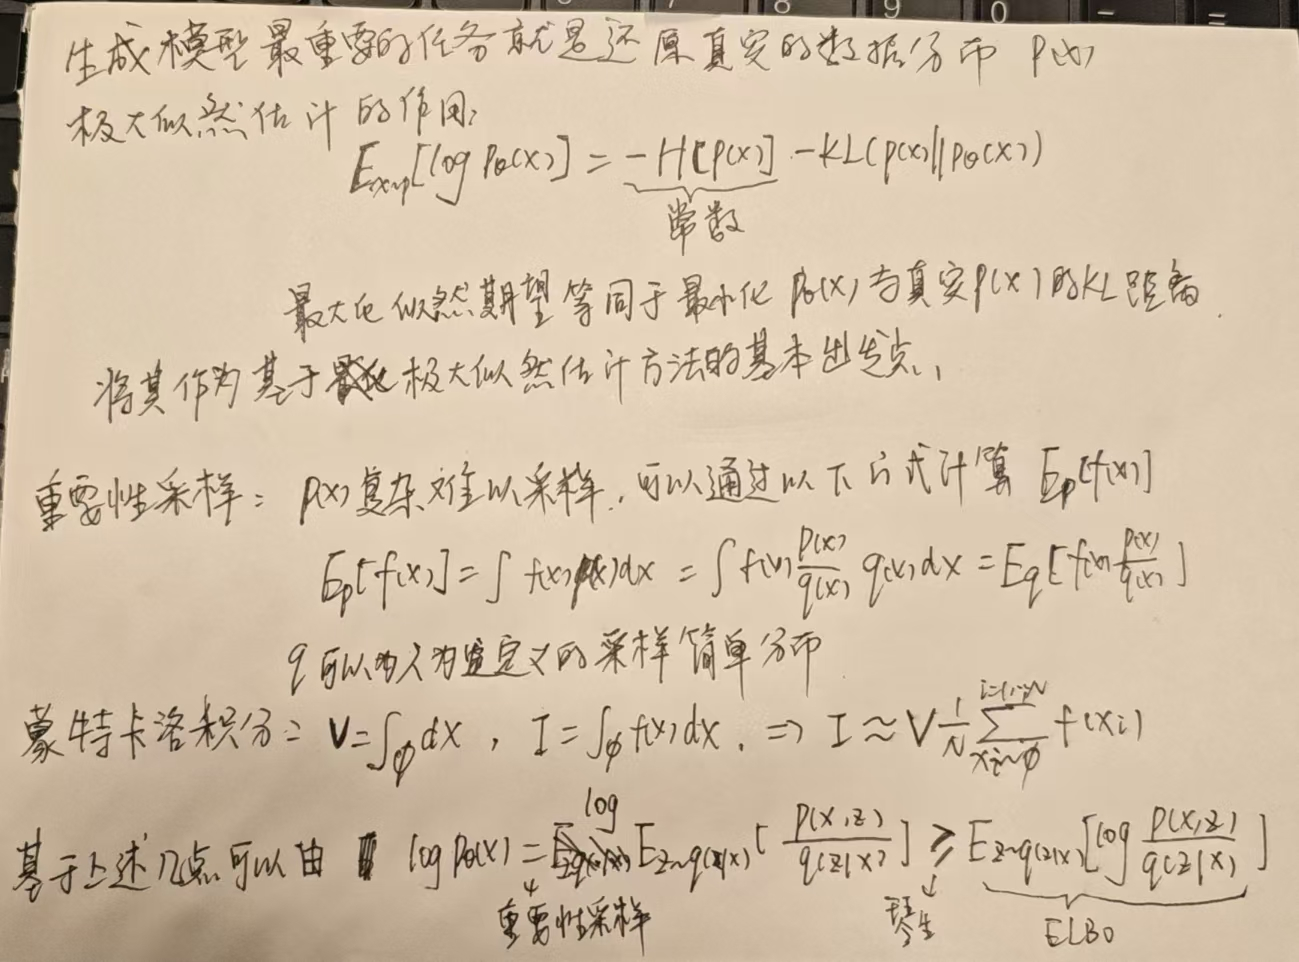

### VAE 简单例子

选择 $p(z) = \mathcal{N}(z; 0, I)，p_\theta(x|z) = \mathcal{N}\big(x; \mu (z;\theta), \sigma^2(z;\theta)\big), q_\phi (z|x) = \mathcal{N}\big(z; \mu(x;\phi), \sigma^2(x;\phi)\big)$

In [4]:
class VAE(nn.Module):
    def __init__(self, dim_x, dim_z):
        super().__init__()
        self.dim_x = dim_x
        self.dim_z = dim_z
        self.encoder = nn.Sequential(
            nn.Linear(dim_x, dim_x * 16),
            nn.ReLU(),
            nn.Linear(dim_x * 16, dim_z * 2)
        )

        self.decoder = nn.Sequential(
            nn.Linear(dim_z, dim_z * 16),
            nn.ReLU(),
            nn.Linear(dim_z * 16, dim_x * 2)
        )

    def forward_encoder(self, input_x):
        # input_x: [b, dim_x]
        tmp_out = self.encoder(input_x)
        # tmp_out: [b, dim_z * 2]
        mu, log_var = tmp_out.split([self.dim_z, self.dim_z], dim=-1)
        return mu, log_var

    def forward_decoder(self, input_z):
        if input_z.ndim == 1:
            input_z = input_z[:, None]

        tmp_out = self.decoder(input_z)
        mu, log_var = tmp_out.split([self.dim_x, self.dim_x], dim=-1)
        return mu, log_var

    def resampling(self, mu, log_var):
        std = torch.sqrt(torch.clamp(torch.exp(log_var), min=1e-6))
        epsilon = torch.randn_like(std)
        return mu + std * epsilon

total_iter = 30000
bs = 200
lr = 5e-5
progress_bar = tqdm(range(total_iter))
D_z = 1
D_x = 2
vae = VAE(D_x, D_z)
optimizer = optim.Adam(vae.parameters(), lr=lr)
freq = 1000

import os
import os.path as osp
import shutil
tmp_dir =  os.path.expanduser("~/Desktop/tmp_dir")
shutil.rmtree(tmp_dir)
os.makedirs(tmp_dir, exist_ok=True)

for i in progress_bar:
    indices = torch.randint(0, num_train, (bs,))
    tmp_x = x[indices]

    mu_z, log_var_z = vae.forward_encoder(tmp_x)

    new_z = vae.resampling(mu_z, log_var_z)

    mu_x, log_var_x = vae.forward_decoder(new_z)

    kl_pz1x_pz = 1 / 2 * (torch.sum(log_var_z, dim=-1) - D_z + torch.sum(torch.exp(log_var_z), dim=-1) + torch.sum(mu_z * mu_z, dim=-1))

    log_px1z = -1 / 2 * (D_x * math.log(math.pi * 2) + torch.sum(log_var_x, dim=-1) + torch.sum((mu_x - tmp_x) ** 2 / torch.clamp(torch.exp(log_var_x), min=1e-6), dim=-1))
    # print(kl_pz1x_pz, log_px1z)
    elbo = torch.mean(log_px1z - kl_pz1x_pz)
    elbo = -elbo  # 梯度下降
    
    if (i + 1) % freq == 0:
        progress_bar.set_postfix(loss=elbo.item())
        torch.save(vae, f"{tmp_dir}/{i + 1}.pth")
    optimizer.zero_grad()
    elbo.backward()
    optimizer.step()


100%|████████████████████████████████████████████████████████████████| 30000/30000 [00:39<00:00, 763.05it/s, loss=-127]


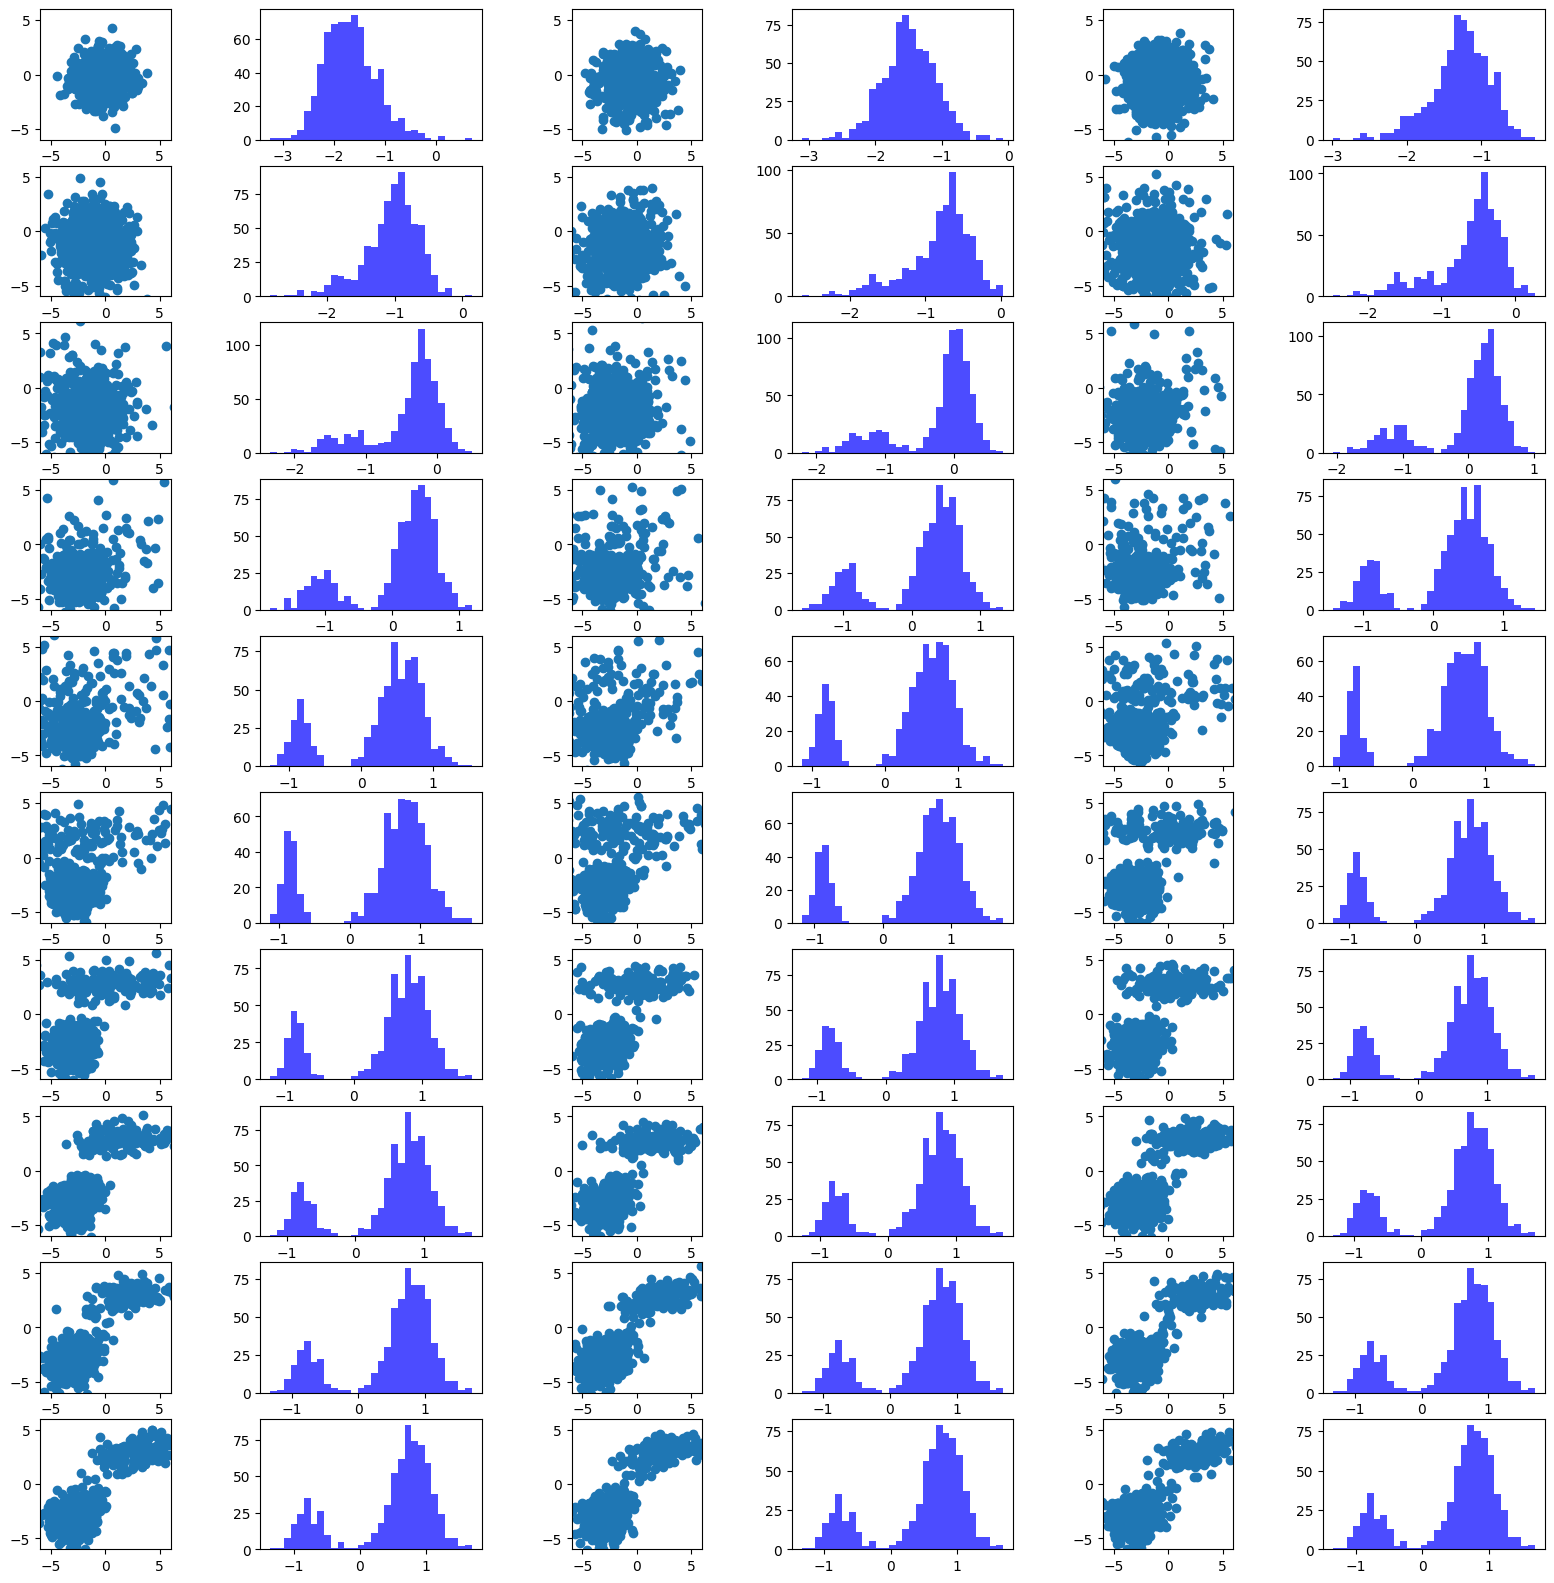

In [102]:
with torch.no_grad():
    total_graph = int(total_iter / freq)
    sqrt = int(math.sqrt(total_graph))
    if sqrt * sqrt == total_graph:
        row = col = sqrt
    elif sqrt * (sqrt + 1) >= total_graph:
        row = sqrt
        col = sqrt + 1
    else:
        row = col = sqrt + 1

    fig, axes_list = plt.subplots(row * 2, col, figsize=(20, 20))
    
    all_lists = []
    for l in axes_list:
        all_lists.extend(l)
        
    for i in range(total_graph):
        net = torch.load(f"{tmp_dir}/{(i + 1) * freq}.pth")
    
        mu_z, log_var_z = net.forward_encoder(x)
        new_z = net.resampling(mu_z, log_var_z)

        mu_x, log_var_x = net.forward_decoder(new_z)
        new_x = net.resampling(mu_x, log_var_x)

#         fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
        all_lists[i * 2].scatter(new_x[:, 0], new_x[:, 1])
        all_lists[i * 2].set_aspect(1)
        all_lists[i * 2].set_xlim([-6,6])
        all_lists[i * 2].set_ylim([-6,6])
        all_lists[i * 2 + 1].hist(new_z[:, 0], bins=30, alpha=0.7, color='blue')
        


## DDPM

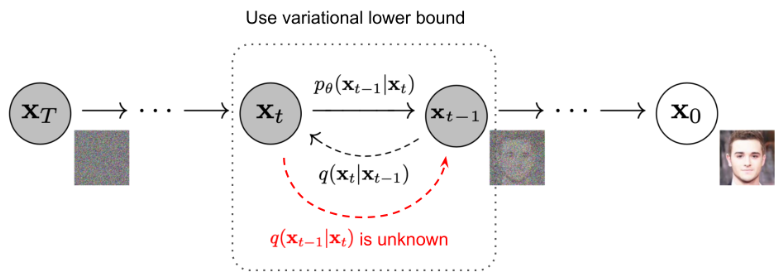

前向过程，一阶马尔可夫链： $q(x_t|x_{t-1}) = \mathcal{N}\left(x_t;\sqrt{\alpha_t}x_{t-1}, (1-\alpha_t)I\right)，0\le\alpha_t<\alpha_{t-1}<1$

通过马尔可夫性质，以及高斯噪声的合并不难得知： $q(x_t|x_0) = \mathcal{N}\left(x_t;\sqrt{\bar{\alpha}_t}x_0, (1- \bar{\alpha}_t)I\right), \bar{\alpha}_t = \Pi_{i=1}^t\alpha_i$

通过利用网络 $\theta$ 拟合反向过程：$p_\theta(x_{t-1}|x_t)$，结合一阶马尔可夫性质，可以得到 $p_\theta(x_0) = \int_{x_{1:T}} p_\theta(x_{0:T})dx_{1:T}= \int_{x_{1:T}} p_\theta(x_T)\Pi_{i=T}^1 p_\theta(x_{t-1}|x_t)dx_{1:T}$

结合 VAE 中使用 ELBO 的做法，使用 $q(x_{1:T}|x_0)$ 作为潜变量，实际上就是让 VAE 中的 $z = x_{1:T}$

可以得到：$\log p_\theta(x_0)\ge \mathbb{E}_{x_{1:T}\sim q(x_{1:T}|x_0)}\left[ \log\frac{p_\theta(x_{0:T})}{q(x_{1:T}|x_0)} \right]$

结合马尔可夫链的性质（前向$q$，反向 $p_\theta$) 可以将分子展开为 $p_\theta (x_{0:T})=p_\theta(x_T)\Pi_{i=T}^1 p_\theta(x_{t-1}|x_t)$

分母可以展开为：$ q(x_{1:T}|x_0) = \Pi_{t=1}^T q(x_{t}|x_{t-1})$

在前向过程的分布中利用马尔可夫性质引入条件 $x_0$ 得到 $q(x_{1:T}|x_0) = q(x_1|x_0)\Pi_{t=2}^T q(x_{t}|x_{t-1}, x_0)$ （实际上直接带着条件 $x_0$ 直接展开应该就是这个形式）

接着使用贝叶斯公式转化为 $q(x_t|x_{t-1},x_0)=\frac{q(x_{t-1}|x_t,x_0)q(x_{t}|x_0)}{q(x_{t-1}|x_0)}$

经过列项相消，以及加上 $x_0$的期望之后，整个loss可以整理成如下形式（详细推导见diffusion.md)

$$
\mathcal{L}_{EVLB} = \mathbb{E}_{x_{0:T}}\left[ \underset{\mathcal{L}_T}{\underbrace{KL(q(x_T|x_0)||p(x_T))}} + \underset{\mathcal{L}_{t-1}, t=2, \cdots, T}{\underbrace{\sum_{t=2}^T KL(q(x_{t-1} | x_{t}, x_0)||p_{\theta}(x_{t-1}|x_t))}} \underset{\mathcal{L}_0}{\underbrace{- \log p_{\theta}(x_0|x_1)}} \right]
$$


其中最关键的：$q(x_{t-1}|x_t,x_0)=\frac{q(x_t|x_{t-1},x_0)q(x_{t-1}|x_0)}{q(x_t|x_0)}$ 实际上可以认为是一个高斯分布（一堆高斯分布的乘除，最后的概率密度形式一定是高斯分布的形式）

通过直接配方法凑平方或者求导法可以解出（将 $x_0 = \frac{1}{\sqrt{\alpha_t}}(x_t - \sqrt{1-\bar{\alpha}_t}\epsilon)$ 代入之后）：

$\mu = \frac{1}{\sqrt{\alpha_t}}(x_t - \frac{1-\alpha_t}{\sqrt{1-\bar{\alpha}_t}}\epsilon),\sigma^2=\frac{1-\bar{\alpha}_{t-1}}{1-\bar{\alpha}_{t}}(1-\alpha_t)I=\tilde{\beta}_t I$

显然我们可以将 $p_\theta(x_{t-1}|x_t)$ 建模为同样的形式 $\mu_\theta = \frac{1}{\sqrt{\alpha_t}}(x_t - \frac{1-\alpha_t}{\sqrt{1-\bar{\alpha}_t}}\epsilon_\theta)$，并且令 $\sigma^2_\theta = \sigma^2$

通过高斯分布的 KL 散度公式，我们可以计算出最后的loss形式：

$\mathcal{L}_{t-1} = \frac{\beta_t^2}{2\tilde{\beta}_t{\alpha}_t(1-\bar{\alpha}_t)} \|\epsilon - \epsilon_\theta(\sqrt{\bar{\alpha}_t}x_0+\sqrt{1-\bar{\alpha}_t}\epsilon, t)\|^2$

不过一般都采用简化形式：

$\mathcal{L}_{t-1} = \|\epsilon - \epsilon_\theta(\sqrt{\bar{\alpha}_t}x_0+\sqrt{1-\bar{\alpha}_t}\epsilon, t)\|^2$

训练完成之后采样方式就是：

$x_{t-1} = \mu_\theta + \sigma_\theta \epsilon = \frac{1}{\sqrt{\alpha_t}}\left(x_t - \frac{1-\alpha_t}{\sqrt{1-\bar{\alpha}_t}}\epsilon_\theta(x_t,t)\right)+\sigma_\theta \epsilon$，$\sigma_\theta$ 可以采用 $\sqrt{\tilde{\beta_t}}$ 或者 $\sqrt{1-\alpha_t}$


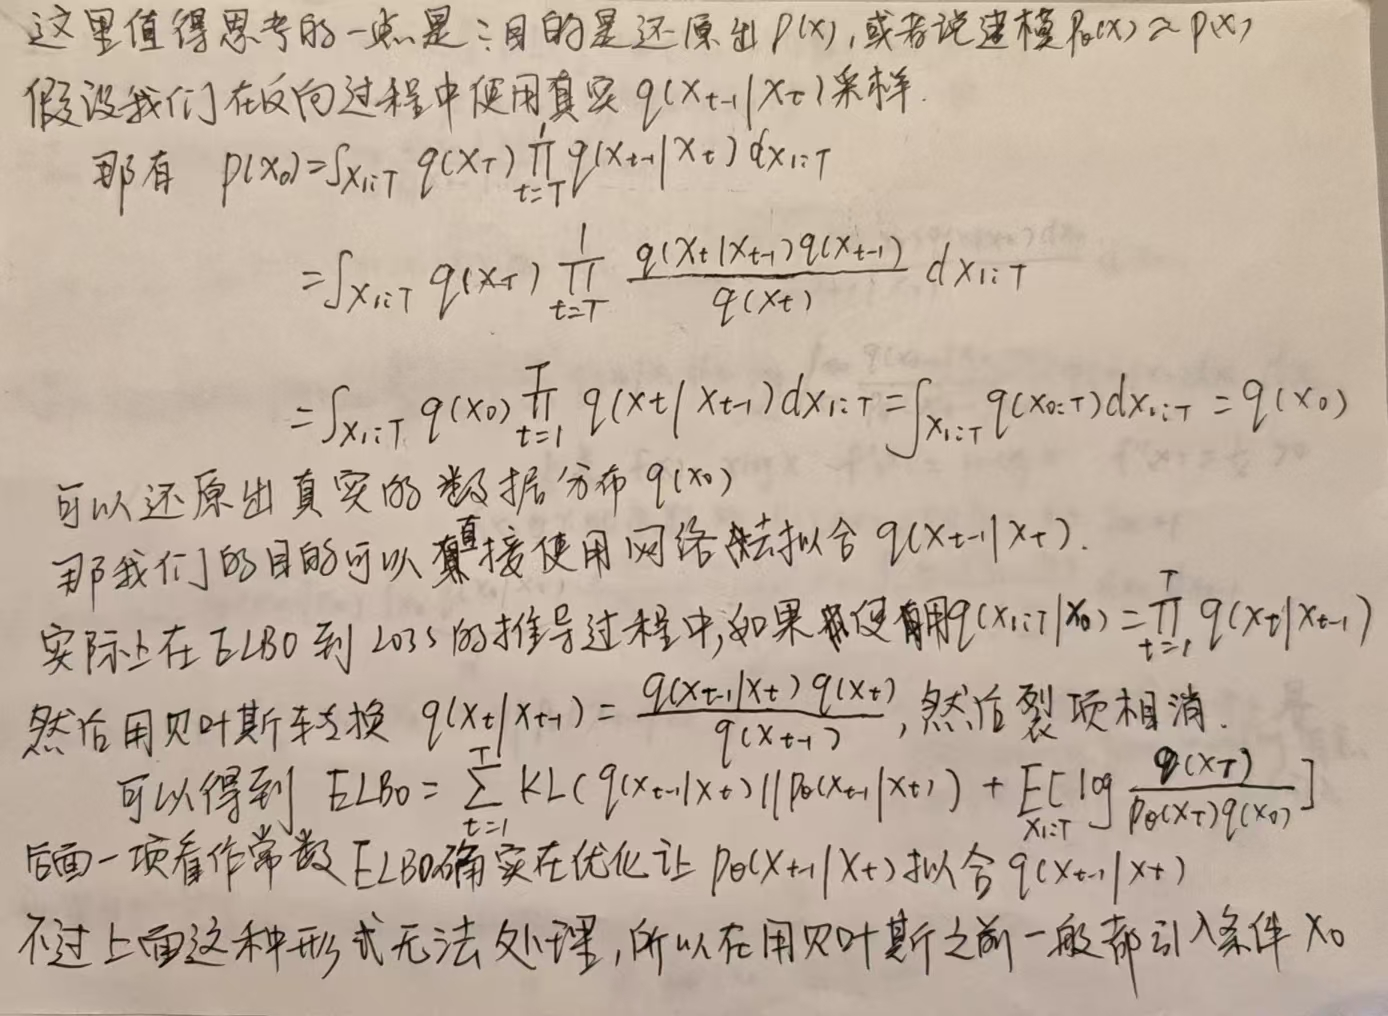

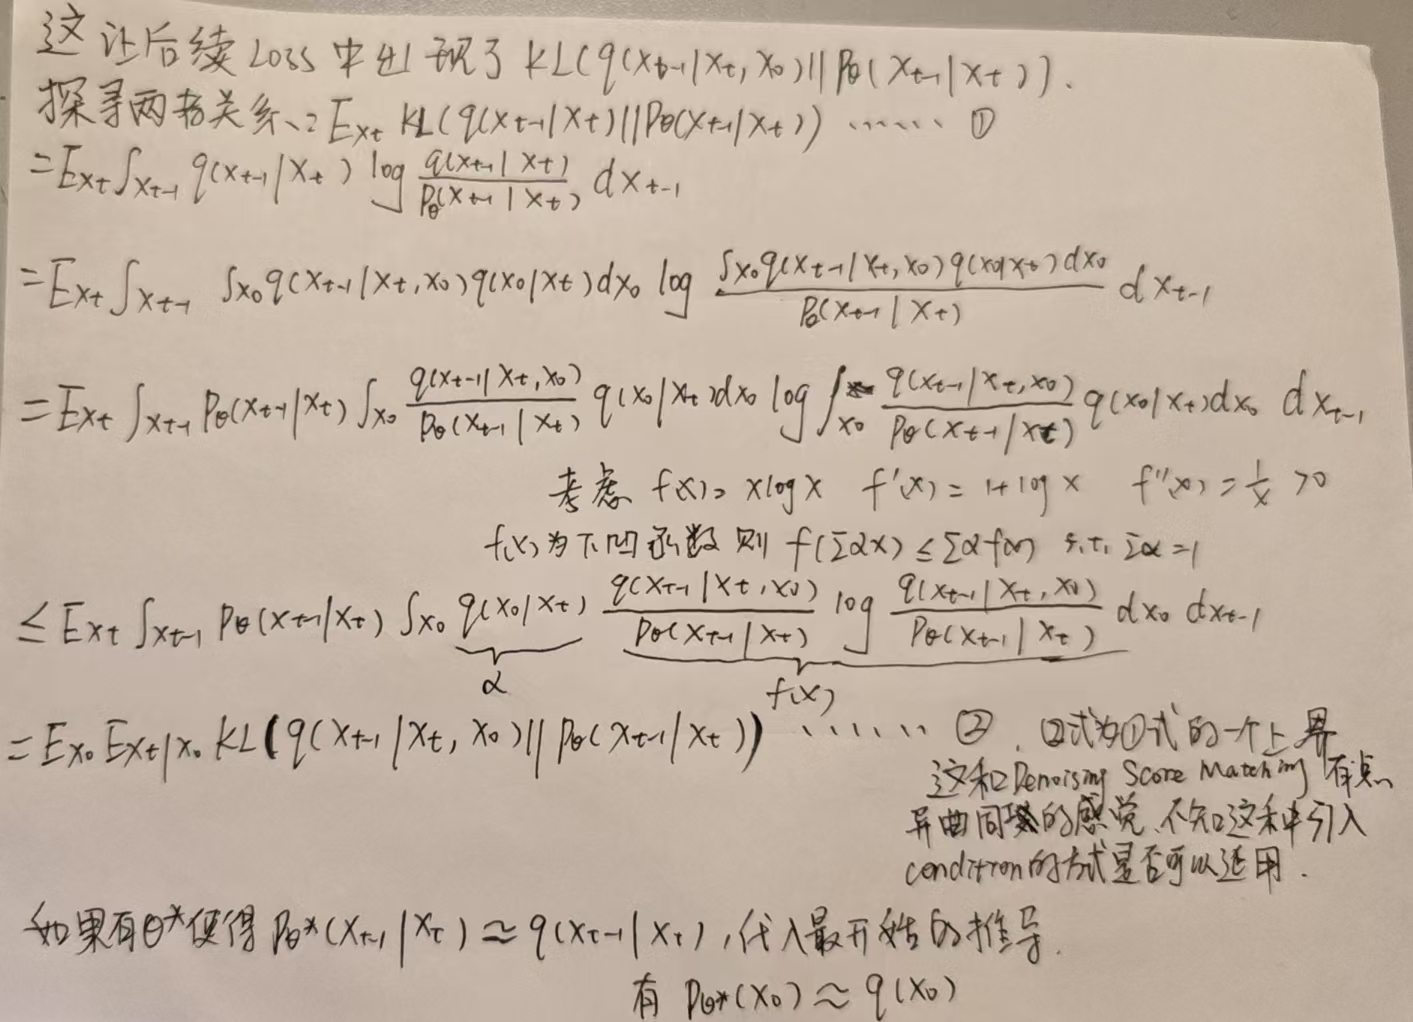

shape of s: (10000, 2)


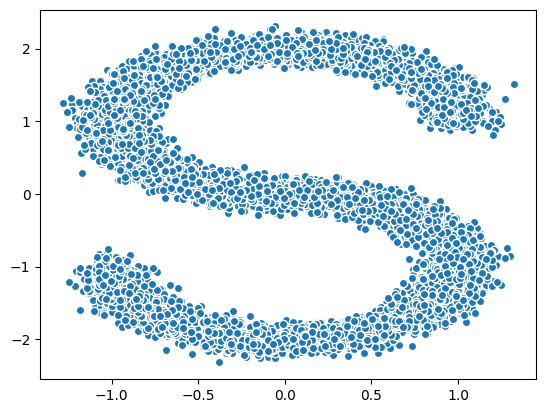

In [77]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import make_s_curve 
import torch
import torch.nn as nn
 
s_curve, _ = make_s_curve(10 ** 4, noise=0.1)  # 10000个数据点
s_curve = s_curve[:, [0, 2]] 
print("shape of s:", np.shape(s_curve))
s_data = torch.Tensor(s_curve).float()
plt.scatter(s_data[:, 0], s_data[:, 1], edgecolors="white")

In [143]:
time_steps = 49

betas = torch.tensor(np.linspace(1e-4, 0.02, time_steps))
alphas = 1 - betas
# sqrt_alphas = torch.sqrt(alphas)
alphas_bar = torch.cumprod(alphas, dim=0)
alphas_bar_pre = torch.cat((torch.tensor([1.0]), alphas_bar[:-1]))
# sqrt_alphas_bar = torch.sqrt(alphas_bar)
# beta_bar = 1 - alphas_bar
# sqrt_beta_bar = torch.sqrt(beta_bar)
loss_weight = betas * betas / (2 * alphas * (1 - alphas_bar) * betas * (1 - alphas_bar_pre) / (1 - alphas_bar))
# 如果按照严格原本loss训练，可以看到必须 t > 1
loss_weight
# 简化后的loss将weight变味了 ones，这导致小的 t 本该受到的约束变得更小了，大的 t 收到的约束变大了

tensor([   inf, 2.5742, 0.7567, 0.4360, 0.3053, 0.2348, 0.1907, 0.1607, 0.1389,
        0.1223, 0.1094, 0.0990, 0.0904, 0.0833, 0.0772, 0.0721, 0.0676, 0.0636,
        0.0602, 0.0571, 0.0544, 0.0519, 0.0497, 0.0477, 0.0459, 0.0442, 0.0427,
        0.0413, 0.0400, 0.0388, 0.0378, 0.0367, 0.0358, 0.0349, 0.0341, 0.0334,
        0.0326, 0.0320, 0.0314, 0.0308, 0.0302, 0.0297, 0.0293, 0.0288, 0.0284,
        0.0280, 0.0276, 0.0273, 0.0270], dtype=torch.float64)

In [147]:
class Unet(nn.Module):
    def __init__(self, in_dim, h_dim, num_step):
        super().__init__()
        self.linear1 = nn.Linear(in_dim, h_dim)
        self.relu1 = nn.ReLU()
        self.linear2 = nn.Linear(h_dim, h_dim)
        self.relu2 = nn.ReLU()
        self.linear3 = nn.Linear(h_dim, h_dim)
        self.relu3 = nn.ReLU()
        self.linear4 = nn.Linear(h_dim,in_dim)
        
        self.embeding1 = nn.Embedding(num_step, h_dim)
        self.embeding2 = nn.Embedding(num_step, h_dim)
        self.embeding3 = nn.Embedding(num_step, h_dim)
    
    def forward(self, x, t):
        x = self.linear1(x)
        x = x + self.embeding1(t)
        x = self.relu1(x)
        
        x = self.linear2(x)
        x = x + self.embeding2(t)
        x = self.relu2(x)
        
        x = self.linear3(x)
        x = x + self.embeding3(t)
        x = self.relu3(x)
        
        x = self.linear4(x)
        
        return x
        
def q_sample(x, t):
    # x_t = \sqrt{\bar{\alpha}_t} x_0 + \sqrt{1 - \bar{\alpha}_t} \epsilon
    # x: [b, in_dim],
    # t: [b]
    epsilon = torch.randn_like(x, dtype=torch.float32)
    # t: [b, 1]
    t = t.reshape(-1, 1)
    # [b, 1]
    sample_alpha_bar = alphas_bar[t]
    w = torch.sqrt(sample_alpha_bar)
    sigma = torch.sqrt(1 - sample_alpha_bar)
    return w * x + sigma * epsilon, epsilon

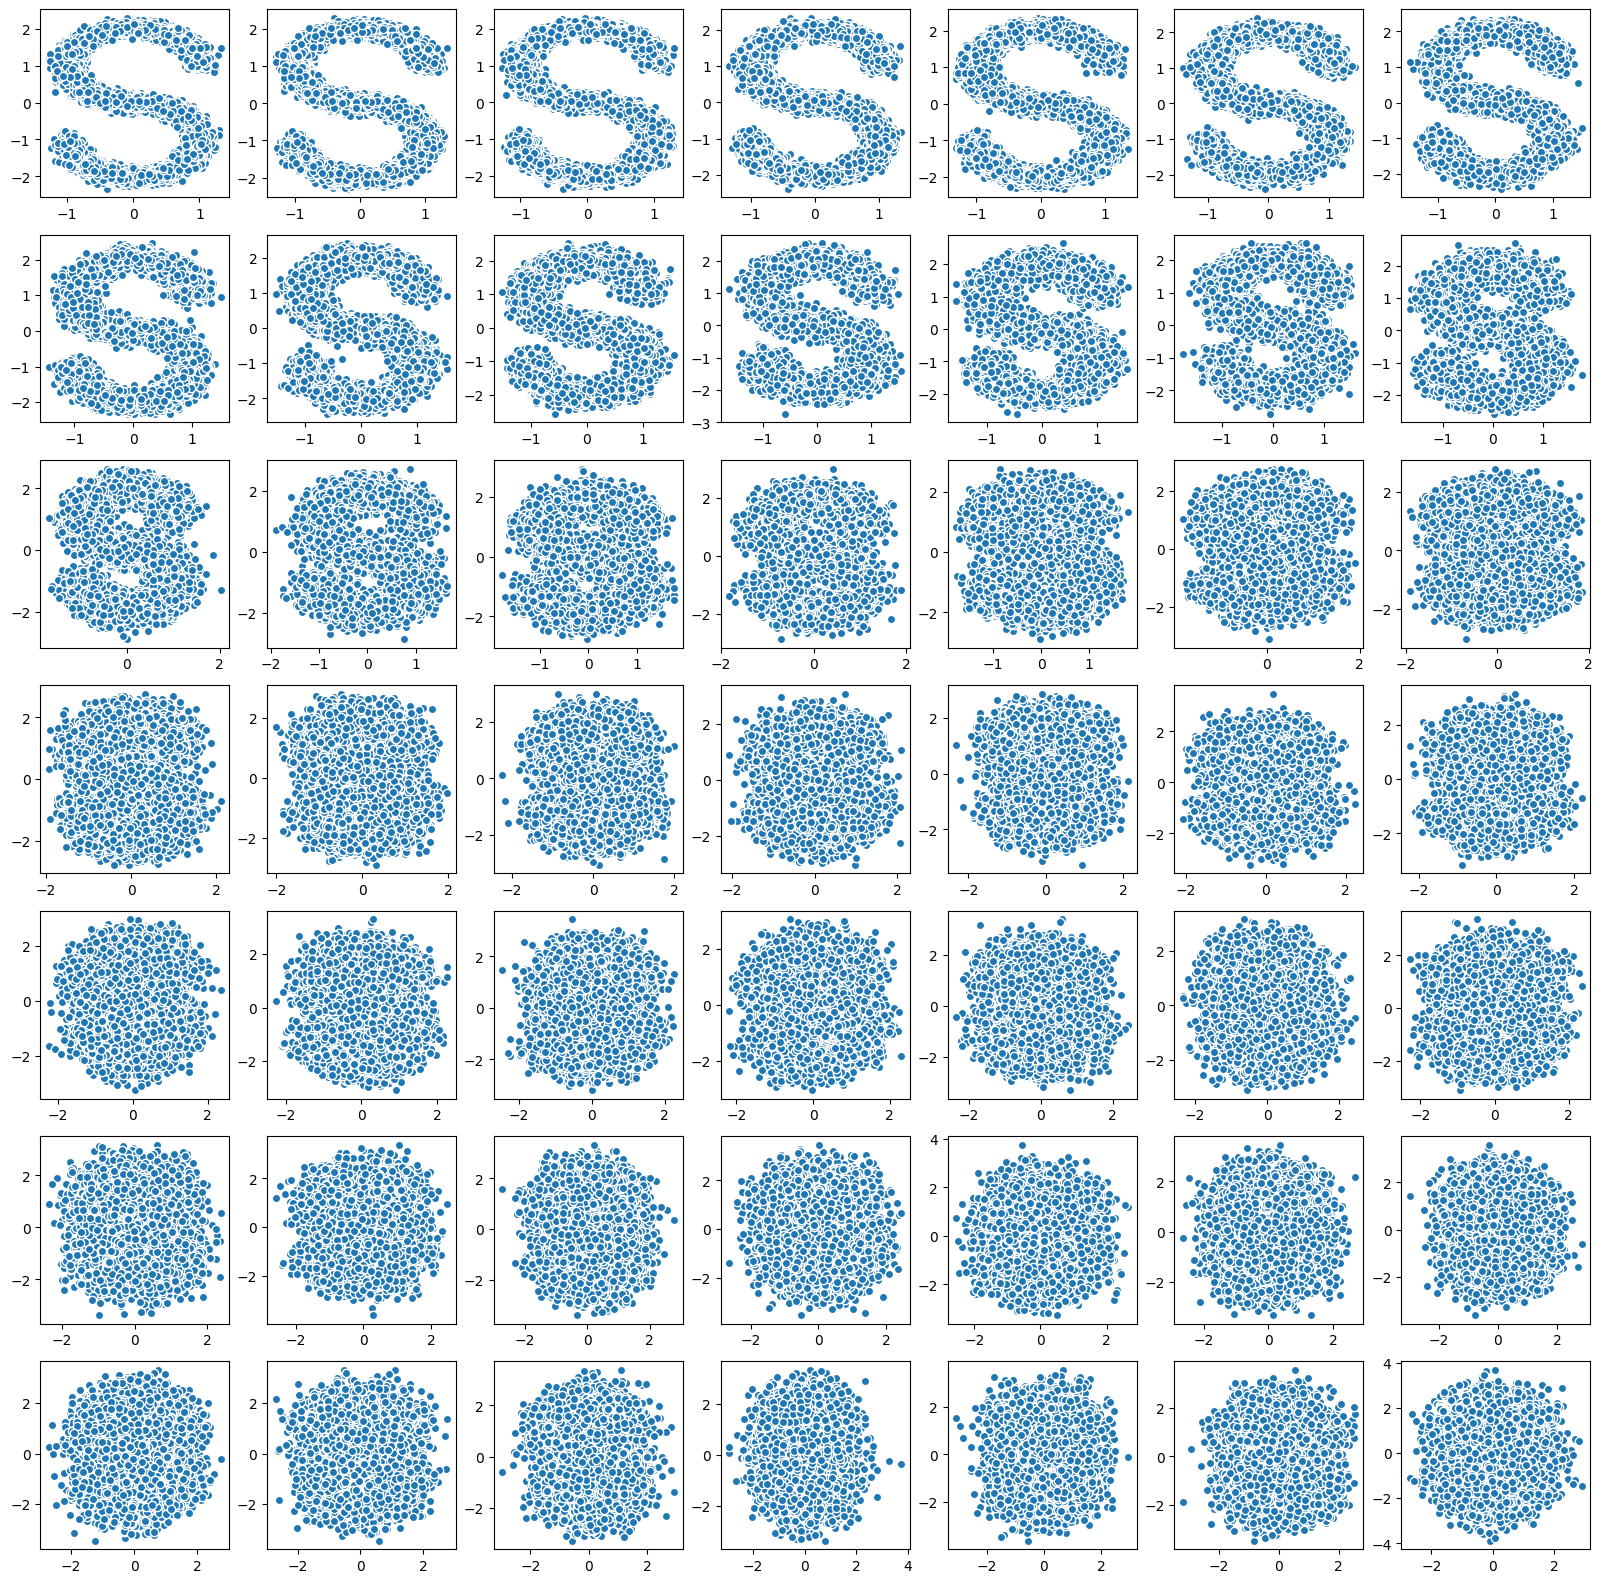

In [148]:
total_graph = time_steps
sqrt = int(math.sqrt(total_graph))
if sqrt * sqrt == total_graph:
    row = col = sqrt
elif sqrt * (sqrt + 1) >= total_graph:
    row = sqrt
    col = sqrt + 1
else:
    row = col = sqrt + 1

fig, axes_list = plt.subplots(row, col, figsize=(20, 20))

all_lists = []
for l in axes_list:
    all_lists.extend(l)
    
for i in range(time_steps):
    x_t, noise = q_sample(s_data, torch.ones(s_data.shape[0]).long() * i)
    all_lists[i].scatter(x_t[:, 0], x_t[:, 1], edgecolors="white")

In [191]:
restrict = False  # 是否用原始 loss
total_iter = 50000
bs = 500
log_freq = 500

net = Unet(2, 128, time_steps).cuda()
optimizer = optim.Adam(net.parameters(), lr=1e-4)
# lr_sch = optim.lr_scheduler.StepLR(optimizer, int(total_iter / 3), gamma=0.1)
net.train()

num_data = len(s_data)
c_iter = 0

bar = tqdm(range(total_iter))

for _ in bar:
    c_iter += 1
    indices = torch.randint(0, num_data, (bs,)) if not restrict else torch.randint(1, num_data, (bs,))
    tmp_x = s_data[indices]
    tmp_t = torch.randint(0, time_steps, (bs,)) if not restrict else torch.randint(1, time_steps, (bs,))
    x_t, noise = q_sample(tmp_x, tmp_t)
    x_t, t, noise = x_t.float().cuda(), tmp_t.cuda(), noise.cuda()
    noise_pre = net(x_t, t)
    
    # 2 维数据
    per_l = torch.sum((noise - noise_pre) ** 2, dim=-1)
    
    loss = torch.mean(per_l) if not restrict else torch.mean(per_l * loss_weight.cuda()[t])
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
#     lr_sch.step()
    
    if not c_iter % log_freq:
        bar.set_postfix(loss=loss.item())
    

100%|████████████████████████████████████████████████████████████████| 50000/50000 [02:16<00:00, 365.68it/s, loss=1.31]


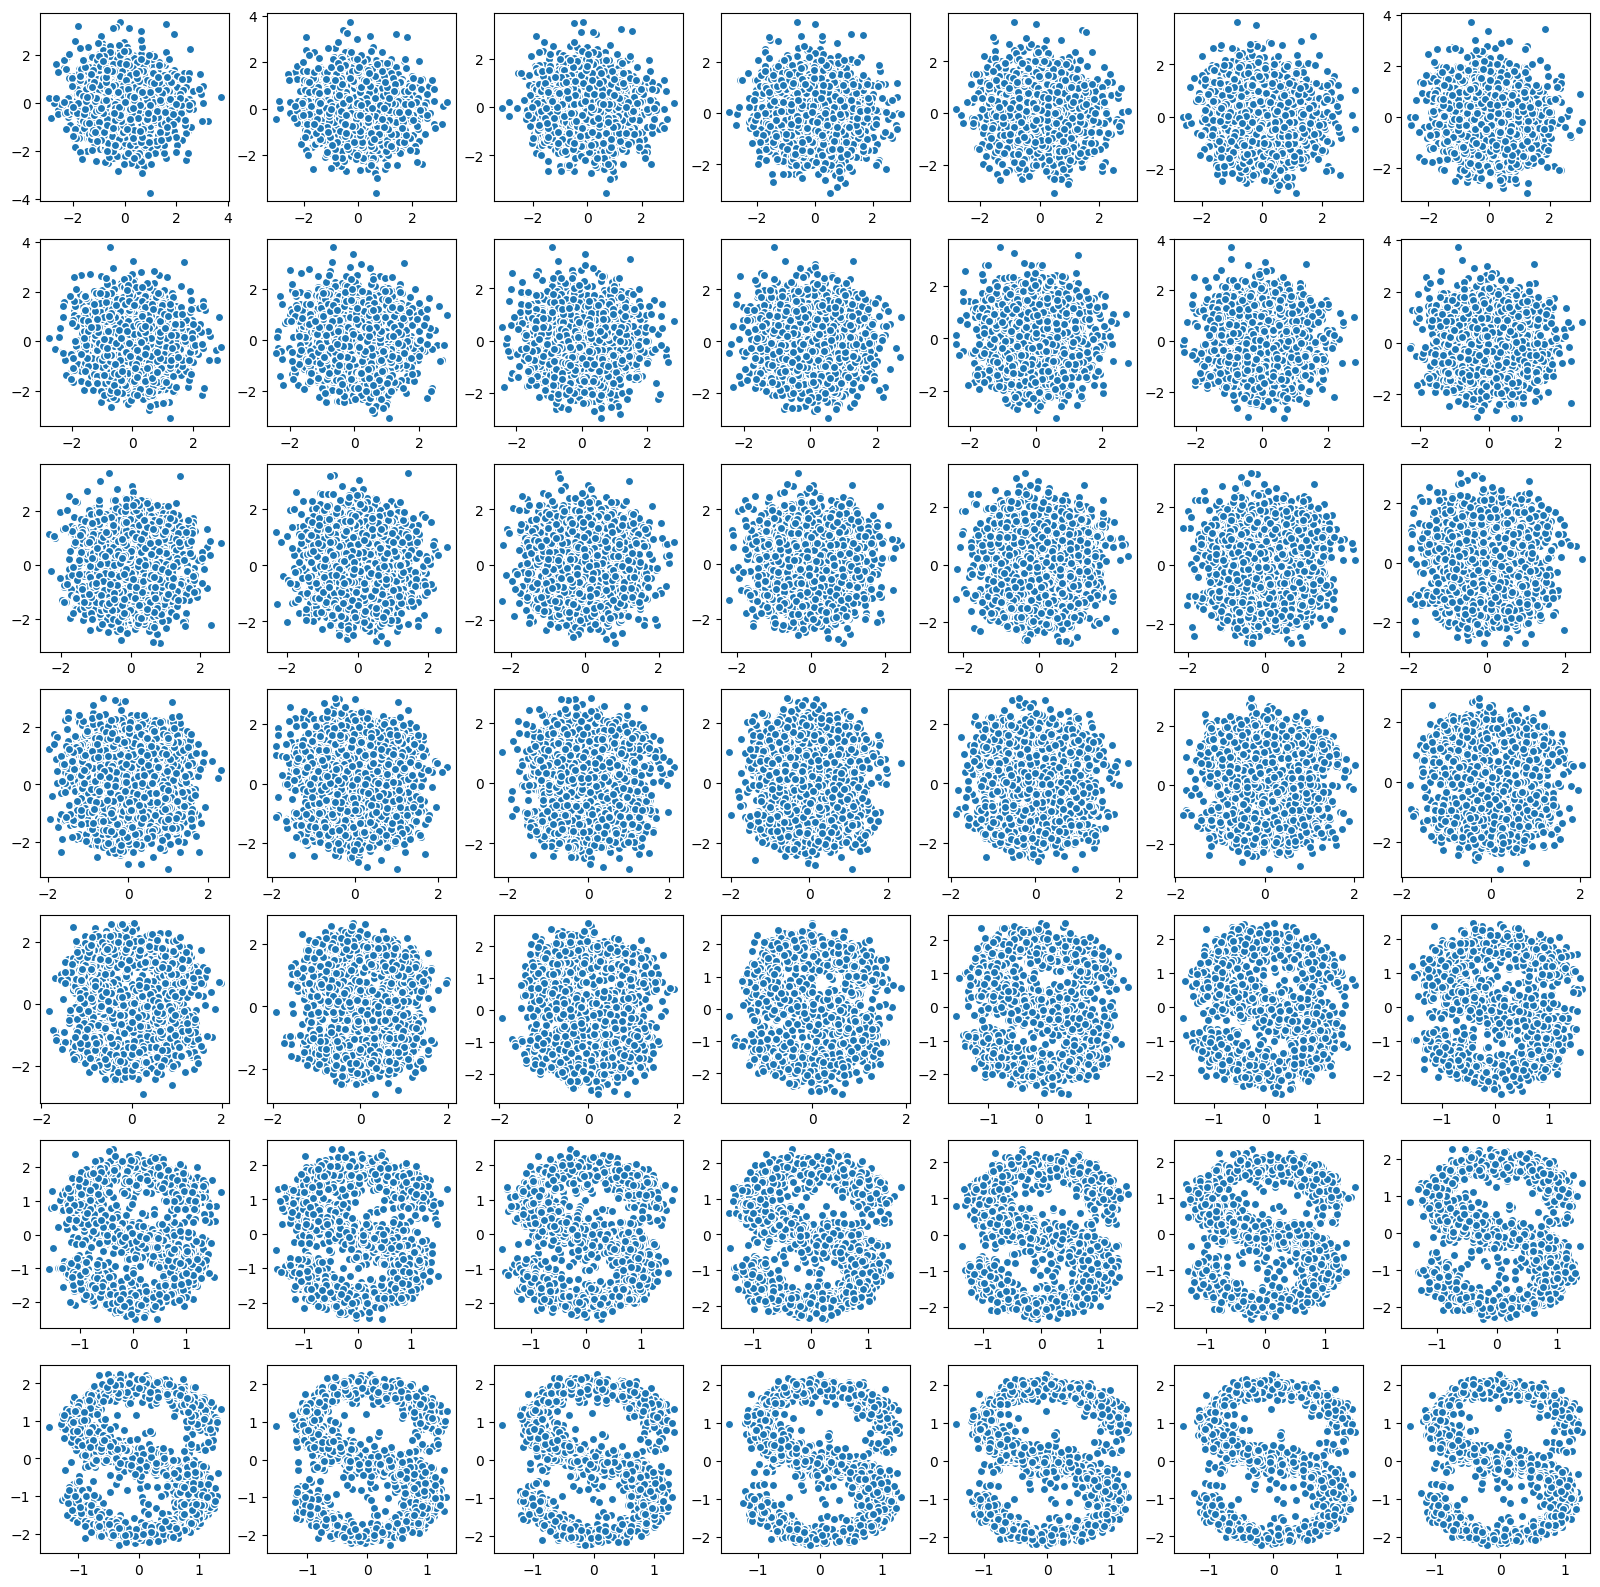

In [197]:
with torch.no_grad():
    net.eval()
    total_graph = time_steps
    sqrt = int(math.sqrt(total_graph))
    if sqrt * sqrt == total_graph:
        row = col = sqrt
    elif sqrt * (sqrt + 1) >= total_graph:
        row = sqrt
        col = sqrt + 1
    else:
        row = col = sqrt + 1

    fig, axes_list = plt.subplots(row, col, figsize=(20, 20))

    all_lists = []
    for l in axes_list:
        all_lists.extend(l)
        
    x = torch.randn((2000, 2)).cuda()
    ones = torch.ones(x.shape[0]).long().cuda()
    ax = all_lists[0]
    ax.scatter(x.cpu()[:, 0], x.cpu()[:, 1], edgecolors="white")
    for t in range(time_steps - 1, 0, -1):
        ax = all_lists[time_steps - t]
        times = ones * t
        noise_pred = net(x, times)
        if t > 0:
            noise = torch.randn_like(noise_pred)
            x = 1 / math.sqrt(alphas[t]) * (x - (1 - alphas[t]) / math.sqrt(1 - alphas_bar[t]) * noise_pred) \
            + math.sqrt((1 - alphas_bar_pre[t]) / (1 - alphas_bar[t]) * (1 - alphas[t])) * noise 
            ax.scatter(x.cpu()[:, 0], x.cpu()[:, 1], edgecolors="white")
        else:
            x = 1 / math.sqrt(alphas[t]) * (x - (1 - alphas[t]) / math.sqrt(1 - alphas_bar[t]) * noise_pred)
            ax.scatter(x.cpu()[:, 0], x.cpu()[:, 1], edgecolors="white")

In [176]:
for t in range(10, 0):
    print(t)